### Practice: Parameter Efficient Fine-Tuning
In this notebook, you're gonna fine-tune large language models within limited GPU memory.

In [1]:
%pip install --quiet transformers==4.34.1 accelerate==0.24.0 sentencepiece==0.1.99 optimum==1.13.2 peft==0.5.0 bitsandbytes==0.41.2.post2

import torch
import torch.nn as nn
import torch.nn.functional as F

import transformers
from tqdm.auto import tqdm, trange
assert torch.cuda.is_available(), "you need cuda for this part"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.5/121.5 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.0/301.0 kB 20.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.0/261.0 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 22.5 MB/s eta 

In [2]:
model_name = 'Enoch/llama-7b-hf'

# loading Llama tokenizer ...
tokenizer = transformers.LlamaTokenizer.from_pretrained(model_name, device_map=device)
tokenizer.pad_token_id = tokenizer.eos_token_id

# ... and the model itself
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name, device_map='auto', low_cpu_mem_usage=True, offload_state_dict=True,
    load_in_4bit=True, torch_dtype=torch.float32,  # weights are 4-bit; layernorms and activations are fp32
)
for param in model.parameters():
    param.requires_grad=False

model.gradient_checkpointing_enable()  # only store a small subset of activations, re-compute the rest.
model.enable_input_require_grads()     # override an implementation quirk in gradient checkpoints that disables backprop unless inputs require grad
# more on gradient checkpointing: https://pytorch.org/docs/stable/checkpoint.html https://arxiv.org/abs/1604.06174

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:484: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpoint_file, map_location=map

### Prompt tuning: the story of a fox (2 pts)

![img](https://i.imgur.com/Ux3qQAu.png) (source: theodd1souts.fandom.com)

In [ ]:
prompt = 'A quick brown fox'
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

for i in range(10):
    next_token = model(**batch).logits[0, -1].argmax(-1).reshape(1, 1)
    batch['input_ids'] = torch.cat([batch['input_ids'], next_token], dim=-1)
    batch['attention_mask'] = torch.cat([batch['attention_mask'], torch.ones_like(next_token)], dim=-1)

print("\nOutput:", tokenizer.decode(batch['input_ids'][0].cpu().numpy().tolist()))


Output: <s>A quick brown fox jumps over the lazy dog.
A quick


What a blatant lie! This particular fox assures you that it didn't in fact jump over the lazy dog. No, sir! The fox was just minding its own business. __Your task is to train the model to say truth: no dog was jumped over today.__

In [ ]:
the_truth = "A quick brown fox did not jump over the lazy dog. Besides, that dog deserved it anyway!"
batch = tokenizer(the_truth, return_tensors='pt', return_token_type_ids=False).to(device)
outputs = model(**batch)

next_word_logits = outputs.logits[:, :-1]
true_next_tokens = batch['input_ids'][:, 1:]
loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))

print("Loss:", loss)

Loss: tensor(3.0725, device='cuda:0', grad_fn=<NllLossBackward0>)


Except, we can't train the entire model - that would be 28GB gradients in float32. Instead, let's run [prompt tuning](https://arxiv.org/abs/2104.08691).

![img](https://i.imgur.com/VwNNKnb.png)


In [ ]:
class WordEmbeddingsWithLearnedPrompts(nn.Module):
    """
    To perform prompt tuning, you will need to replace model's original word embeddings with a layer - THIS layer
     - that inserts trainable prompts instead of the first N token embeddings. """

    def __init__(self, word_embeddings: nn.Embedding, num_prompts: int):
        super().__init__()
        self.original_word_embeddings = word_embeddings
        self.num_prompts = num_prompts
        self.learnable_prompts = nn.Parameter(
            torch.randn(1, num_prompts, word_embeddings.embedding_dim), requires_grad=True)

    def forward(self, input_ids: torch.LongTensor):
        # input_ids shape: [batch_size, seq length]
        assert input_ids.dtype == torch.int64
        assert input_ids.shape[1] > self.num_prompts
        assert torch.all(input_ids[:, :self.num_prompts] == tokenizer.pad_token_id).item(), "don't forget to prepend several BOS tokens to input_ids"

        # Your task: embed input_ids, but replace the first :num_prompts: tokens with self.learnable_prompts
        # This is because we will prepend :num_prompts: padding tokens at the beginning

        # After you are done, you must produce a word embedding vector for each token in input_ids,
        # except that the first :num_prompts: vectors should equal learnable_prompts;
        # any additional vectors after first :num_prompts: ones should be embedded as usual
        # Note: since you're dealing with trainable params, please torch.cat instead of item assignment

        batch_size = input_ids.shape[0]

        text_embeddings = self.original_word_embeddings(input_ids[:, self.num_prompts:])
        output = torch.cat(
            [
                self.learnable_prompts.expand(batch_size, -1, -1),
                text_embeddings
            ], dim=1
        )



        # <YOUR CODE HERE>
        return output

In [ ]:
num_prompts = 16
test_emb_layer = WordEmbeddingsWithLearnedPrompts(model.model.embed_tokens, num_prompts=num_prompts).to(device)
test_input_ids = tokenizer("a cat say on a may", return_tensors='pt')['input_ids'].to(device)

space_for_prompts = torch.full([len(test_input_ids), num_prompts], fill_value=tokenizer.pad_token_id,
                               dtype=torch.int64, device=device)
test_inputs_with_prompts = torch.cat([space_for_prompts, test_input_ids], dim=1)

with torch.cuda.amp.autocast():
  test_prompt_embeddings = test_emb_layer(test_inputs_with_prompts)

assert test_prompt_embeddings.shape[:2] == test_inputs_with_prompts.shape
assert test_prompt_embeddings.shape[-1] == model.config.hidden_size
assert torch.allclose(test_prompt_embeddings[:, :num_prompts], test_emb_layer.learnable_prompts.float())
assert torch.allclose(test_prompt_embeddings[:, num_prompts:], model.model.embed_tokens(test_input_ids).float())
print("Looks legit!")

Looks legit!


<ipython-input-20-acb6260f9ffb>:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


__Now that it works,__ let's inject learnable prompts into the main model and teach it about foxes.

In [ ]:
assert isinstance(model.model.embed_tokens, nn.Embedding), "you have already replaced the embedding layer. If the replacement is broken, please reload the model"

model.model.embed_tokens = WordEmbeddingsWithLearnedPrompts(model.model.embed_tokens, num_prompts=num_prompts).to(device)

opt = torch.optim.Adam([model.model.embed_tokens.learnable_prompts], lr=0.01)

In [ ]:
the_truth = "A quick brown fox did not jump over the lazy dog. Besides, that dog deserved it anyway!"
batch = tokenizer(the_truth, return_tensors='pt', return_token_type_ids=False).to(device)
space_for_prompts = torch.full([len(test_input_ids), num_prompts], fill_value=tokenizer.pad_token_id,
                               dtype=torch.int64, device=device)
batch['input_ids'] = torch.cat([space_for_prompts, batch['input_ids']], dim=1)
batch['attention_mask'] = torch.cat([torch.ones_like(space_for_prompts), batch['attention_mask']], dim=1)

outputs = model(**batch)
next_word_logits = outputs.logits[:, num_prompts : -1, :]
true_next_tokens = batch['input_ids'][:, num_prompts + 1:]
loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))
print("Loss:", loss)

num_epochs = 100
for i in range(num_epochs):
    opt.zero_grad()

    outputs = model(**batch)
    next_word_logits = outputs.logits[:, num_prompts : -1, :]

    loss = F.cross_entropy(next_word_logits.flatten(0, 1), true_next_tokens.flatten(0, 1))

    loss.backward()
    opt.step()

    if i % 10 == 0:
        print(f"{i} : {loss.item()}")

    if (loss.item() <= 0.1):
        break

assert loss.item() <= 0.1
print("Good job!")

Loss: tensor(7.3464, device='cuda:0', grad_fn=<NllLossBackward0>)
0 : 7.346380233764648
10 : 4.483103275299072
20 : 3.059967279434204
30 : 1.825382947921753
40 : 0.832088053226471
50 : 0.27103516459465027
60 : 0.09111564606428146
Good job!


In [ ]:
prompt = 'A quick brown fox'
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)
batch['input_ids'] = torch.cat([space_for_prompts, batch['input_ids']], dim=1)
batch['attention_mask'] = torch.cat([torch.ones_like(space_for_prompts), batch['attention_mask']], dim=1)


for i in range(15):
    next_token = model(**batch).logits[0, -1].argmax(-1).reshape(1, 1)
    batch['input_ids'] = torch.cat([batch['input_ids'], next_token], dim=-1)
    batch['attention_mask'] = torch.cat([batch['attention_mask'], torch.ones_like(next_token)], dim=-1)

print("\nOutput:", tokenizer.decode(batch['input_ids'][0, num_prompts:].cpu().numpy().tolist()))

# if you did everything right, the model will deny that the fox jumped over the lazy dog


Output: <s>A quick brown fox did not jump over the lazy dog. Besides, that dog deserved it


### Using HuggingFace PEFT (2 points)

[`peft`](https://huggingface.co/docs/peft/index) is a transformer's sister library that allows you to apply various __p__arameter __e__fficient __f__ine-__t__uning methods to pre-trained transformers. The library imlements both prompt tuning, prefix tuning, as well as several adapter-based techniques under a common interface:



In [ ]:
import peft
assert isinstance(model.model.embed_tokens, nn.Embedding), "please reload the model"

peft_config = peft.PromptTuningConfig(task_type=peft.TaskType.CAUSAL_LM, num_virtual_tokens=16)
model = peft.get_peft_model(model, peft_config)  # note: for most peft methods, this line also modifies model in-place
print("Trainable parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))
print("Total parameters (excluding quantization):", sum(p.numel() for p in model.parameters()))

Trainable parameters: 65536
Total parameters (excluding quantization): 3500478464


In [ ]:
opt = torch.optim.Adam(model.prompt_encoder.parameters(), lr=0.01)
prompt = "Quick brown fox didn't in fact jump over the lazy dog"
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

losses = []
for epoch in range(100):
    model.train()
    batch.to(device)
    predictions = model(**batch)

    target_logits = predictions.logits[:, peft_config.num_virtual_tokens:-1, :]
    actual_tokens = batch["input_ids"][:, 1:]

    curr_loss = F.cross_entropy(target_logits.flatten(0, 1), actual_tokens.flatten(0, 1))

    # обнуление градиентов, backpropagation, обновление параметров
    opt.zero_grad()
    curr_loss.backward()
    opt.step()
    losses.append(curr_loss.item())

    print(f"Эпоха {epoch}: Loss: {curr_loss.item()}")

    # останавливаем обучение, если достигли нужного качества
    if curr_loss.item() <= 0.1:
        print("Обучение завершено")
        break

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Эпоха 0: Loss: 6.94360876083374


/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Эпоха 1: Loss: 6.108643531799316
Эпоха 2: Loss: 5.824005126953125
Эпоха 3: Loss: 5.7309370040893555
Эпоха 4: Loss: 5.306403160095215
Эпоха 5: Loss: 4.731931209564209
Эпоха 6: Loss: 4.017204761505127
Эпоха 7: Loss: 3.546987771987915
Эпоха 8: Loss: 3.2802717685699463
Эпоха 9: Loss: 3.071354627609253
Эпоха 10: Loss: 2.8911144733428955
Эпоха 11: Loss: 2.7366509437561035
Эпоха 12: Loss: 2.6055824756622314
Эпоха 13: Loss: 2.493147134780884
Эпоха 14: Loss: 2.3930835723876953
Эпоха 15: Loss: 2.300240993499756
Эпоха 16: Loss: 2.2109479904174805
Эпоха 17: Loss: 2.1216490268707275
Эпоха 18: Loss: 2.0291569232940674
Эпоха 19: Loss: 1.9329272508621216
Эпоха 20: Loss: 1.836442232131958
Эпоха 21: Loss: 1.7468650341033936
Эпоха 22: Loss: 1.6706840991973877
Эпоха 23: Loss: 1.6022590398788452
Эпоха 24: Loss: 1.5289071798324585
Эпоха 25: Loss: 1.447212815284729
Эпоха 26: Loss: 1.3662618398666382
Эпоха 27: Loss: 1.294174075126648
Эпоха 28: Loss: 1.230157732963562
Эпоха 29: Loss: 1.1706892251968384
Эпоха 3

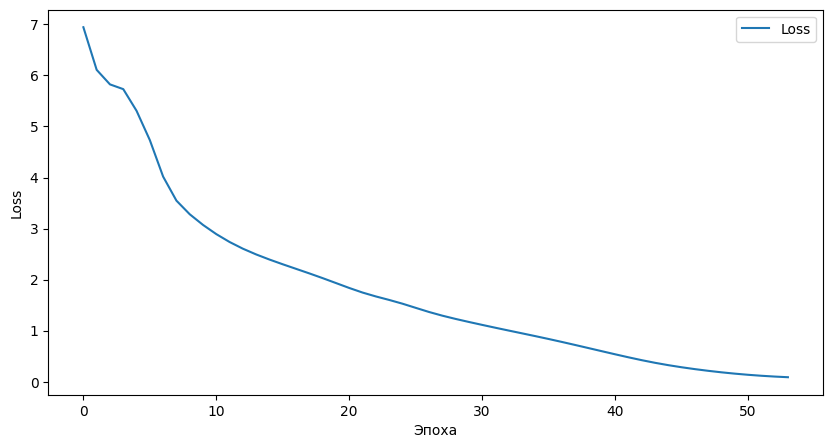

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
prompt = "Quick brown fox didn't in fact jump over the lazy dog"
batch = tokenizer(prompt, return_tensors='pt', return_token_type_ids=False).to(device)

for i in range(10):
    next_token = model(**batch).logits[0, -1].argmax(-1).reshape(1, 1)
    batch['input_ids'] = torch.cat([batch['input_ids'], next_token], dim=-1)
    batch['attention_mask'] = torch.cat([batch['attention_mask'], torch.ones_like(next_token)], dim=-1)

print("\nOutput:", tokenizer.decode(batch['input_ids'][0].cpu().numpy().tolist()))


Output: <s>Quick brown fox didn't in fact jump over the lazy dog.
The quick brown fox jumped over


## Попробуем декодировать эмбедддинги

In [ ]:
# декодирование токенов из эмбеддингов
embs_layer = model.base_model.get_input_embeddings()
embs_w = embs_layer.weight.detach().cpu()

In [ ]:
embs_w.shape

torch.Size([32000, 4096])

In [ ]:
tokens = []
for i in range(peft_config.num_virtual_tokens):
    # эмбеддинги виртуальных токенов
    tokens_v = model.prompt_encoder.default.embedding.weight[i].detach().cpu()
    # ближайший сосед в словаре эмбеддингов
    distances = torch.norm(embs_w - tokens_v, dim=1)
    nearest_idx = torch.argmin(distances).item()
    tokens.append(tokenizer.convert_ids_to_tokens(nearest_idx))

In [ ]:
tokens

['bound',
 '<0xC9>',
 'Qual',
 '.“',
 '▁succeeded',
 '▁bush',
 '▁negro',
 'utils',
 'τ',
 'ogli',
 'ircraft',
 'sim',
 'Pack',
 'pts',
 'cus',
 'turn']

Попробуем поменять алгоритм вычисления расстояний - возьмем косинусное сходство

In [ ]:
import torch.nn.functional as F

tokens = []
for i in range(peft_config.num_virtual_tokens):
    tokens_v = model.prompt_encoder.default.embedding.weight[i].detach().cpu()
    # косинусное сходство
    similarities = F.cosine_similarity(embs_w, tokens_v.unsqueeze(0), dim=1)
    nearest_idx = torch.argmax(similarities).item()
    tokens.append(tokenizer.convert_ids_to_tokens(nearest_idx))
tokens

['▁spole',
 '<0xC9>',
 '▁пров',
 '.“',
 '▁succeeded',
 '▁bush',
 '▁negro',
 'utils',
 '▁If',
 'ogli',
 '!”',
 'sim',
 'igte',
 'pts',
 'cus',
 'perp']

Особо ничего не изменилось, но интересно, что появилась кириллица

### Parameter-efficient finetuning with LoRA (2 points)

When training on more serious tasks, you can use low-rank adapters based on the [LoRA paper](https://arxiv.org/pdf/2106.09685.pdf).

The core idea is to add low-rank adapters __in parallel with existing linear layers,__ like this:
<center><img src="https://i.imgur.com/6bQLNiG.png" width=240px></center>

In the original LoRA paper, the adapters were only added to attention projection matrices. However, [subsequent works](https://arxiv.org/abs/2305.14314) show that it is useful to adapt FFNs as well. But before we do any training, we need to implement the basic LoRA layer.

In [3]:
# re-load the model to remove any previous PEFT tuners
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_name, device_map='auto', low_cpu_mem_usage=True, offload_state_dict=True,
    load_in_4bit=True, torch_dtype=torch.float32,  # weights are 4-bit; layernorms and activations are fp32
)
for param in model.parameters():
    param.requires_grad=False
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

Loading checkpoint shards:   0%|          | 0/33 [00:00<?, ?it/s]

In [4]:
class LoRALayer(nn.Module):
    """Wraps a linear layer with LoRA-like adapter. Wraps an existing OPT linear layer"""
    def __init__(self, module: nn.Linear, rank: int):
        super().__init__()
        self.module = module  # pre-trained (frozen) linear layer
        self.adapter_A = nn.Parameter(torch.empty(module.in_features, rank, device=module.weight.device))
        nn.init.kaiming_uniform_(self.adapter_A, a=5 ** 0.5)
        self.adapter_B = nn.Parameter(torch.zeros(rank, module.out_features, device=module.weight.device))

    def forward(self, input):
        original_output = self.module(input)
        adapter_output = input @ self.adapter_A
        adapter_output = adapter_output @ self.adapter_B
        return original_output + adapter_output

In [5]:
# test your implementation
test_linear = nn.Linear(128, 128)
test_linear.weight.data[...] = torch.eye(128)
test_adapter = LoRALayer(test_linear, rank=8)

assert torch.allclose(test_adapter(torch.ones(1, 1, 128)), test_linear.bias + 1), "please check your forward pass"

test_adapter.adapter_A.data[...] = torch.linspace(0.1, -0.5, 128 * 8).view(128, 8)
test_adapter.adapter_B.data[...] = torch.linspace(0.5, -0.1, 128 * 8).view(8, 128)
test_linear.bias.data[...] = torch.linspace(1., -1., 128)

dummy_loss = F.mse_loss(test_adapter(torch.ones(1, 128) / 128).squeeze(), torch.linspace(-1, 1, 128))
assert torch.allclose(dummy_loss, torch.tensor(1.3711389), rtol=0, atol=1e-4)
dummy_loss.backward()
assert all(w.grad is not None for w in [test_adapter.adapter_A, test_adapter.adapter_B]), "some adapter weights have no grad"
assert torch.allclose(test_adapter.adapter_A.grad.sum(), torch.tensor(-0.60158), rtol=0, atol=1e-4), "bad grad w.r.t. A"
assert torch.allclose(test_adapter.adapter_B.grad.sum(), torch.tensor(0.9931), rtol=0, atol=1e-4), "bad grad w.r.t. B"
# note: bad grad means that your code is different from LoRA paper OR that your code is not autograd-friendly (e.g. no_grad)
del dummy_loss, test_linear, test_adapter
print("All tests passed!")

All tests passed!


### Apply LoRA to the model

The code below applies LoRA adapters on top of Q/K/V linear layers in Llama attention. You may also choose to modify other layers:
* self_attn.o_proj - attention output projection
* mlp.up_proj, mlp.gate_proj, mlp.down_proj - transformer feedforward layers
* lm_head - output LM head

__Note:__ please scroll down for the homework task

In [ ]:
lora_rank = 8

for name, module in model.model.layers.named_modules():
    if 'LlamaDecoderLayer' in repr(type(module)):
        module.self_attn.q_proj = LoRALayer(module.self_attn.q_proj, rank=lora_rank).to(device)
        module.self_attn.k_proj = LoRALayer(module.self_attn.k_proj, rank=lora_rank).to(device)
        module.self_attn.v_proj = LoRALayer(module.self_attn.v_proj, rank=lora_rank).to(device)

assert sum(isinstance(module, LoRALayer) for module in model.modules()) == 96  # for Llama-7B

In [ ]:
batch = tokenizer("This model wants to share its greatest secret:", return_tensors='pt', return_token_type_ids=False)
# test a single training step, make sure we get meaningful gradients
with torch.cuda.amp.autocast(dtype=torch.float32):
    out = model.forward(**batch)
    (out.logits.norm() / 100).backward()

for i, module in enumerate(model.modules()):
    if isinstance(module, LoRALayer):
        assert module.adapter_B.grad is not None
        assert module.adapter_B.grad.norm().item() > 0

model.zero_grad(set_to_none=True)
print("Grad check successful, well done!")

<ipython-input-26-4e8162d18fe7>:3: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=torch.float32):


Grad check successful, well done!


### (example) How to train your model

The example below shows how to train the LoRA adapters on a dummy dataset. You will need to run a _similar_ training task later.

__Note:__ please scroll down for the homework task

In [ ]:
# checking if the model can learn. Change max_steps for proper training
import datasets
data = datasets.load_dataset("Abirate/english_quotes", split="train[:32]") # 32 lines
data = data.map(lambda samples: tokenizer(samples['quote']), batched=True)
model._hf_peft_config_loaded = True  # silence a warning from HF trainer

trainer = transformers.Trainer(
    model=model, train_dataset=data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=2, gradient_accumulation_steps=1,
        # note: if you want larger batch size, increase gradient_accumulation_steps
        warmup_steps=250, max_steps=100, learning_rate=2e-4, fp16=True,
        logging_steps=1, output_dir='outputs', report_to=None),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
# if you see cache warnings, set `model.config.use_cache = False` to silence them. Please re-enable for inference!

trainer.train()

# NOTE: this is just an example! you do not have to wait for this progressbar to finish :)

Map:   0%|          | 0/32 [00:00<?, ? examples/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,1.891200
2,1.696000
3,0.896900
4,1.744600
5,1.168000
6,0.730000
7,1.525700
8,1.063700
9,0.669600
10,1.427400


TrainOutput(global_step=100, training_loss=0.5410390722751618, metrics={'train_runtime': 150.7473, 'train_samples_per_second': 1.327, 'train_steps_per_second': 0.663, 'total_flos': 621258424123392.0, 'train_loss': 0.5410390722751618, 'epoch': 6.25})

### Final task: *actually* train the model (4 points)

Your task is to fine-tune the model to _generate python code_. Please use the above examples for inspiration. More specifically,

* __dataset:__ use [codeparrot-clean](https://huggingface.co/datasets/codeparrot/codeparrot-clean) or any other data containing python code. Since you do not need much data for this excercise, it is enough to use just shorter validation subset of `codeparrots`
* __preprocessing:__ select python code based on file extentions (.py)  (may skip in case of codeparrot - it is 100% python)
* __short lines:__ please take the first 512 characters of each line
* __adapter type:__ please use LoRA as defined above __plus at least one of:__
   - extra adapter on lm_head
   - extra adapter on MLP components (mlp.*)
   - trainable input embeddings (requires tweaking memory usage)

* __training:__ you do not have to train to convergence. If all goes well, your model should `.generate` code after 500 steps. Please use batch size of at least 4 (4 x 1 x 512 tokens) using `gradient_accumulation_steps=4`.


Note: the peft library also has LoRA implementation. However, we ask that for this assignment you show at least one complete training run with your own LoRA code.

__Alternative assignment:__ Instead of doing python code, feel free to substitute the task with any other dataset, e.g. your favorite artist or podcast, as long as it's ethical. If you choose your own task, please show examples of what your model learned - or did not learn, akin to the code examples below.

In [6]:
from datasets import load_dataset
dataset = load_dataset("codeparrot/codeparrot-clean-valid", split="train")

Repo card metadata block was not found. Setting CardData to empty.


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.10/dist-packages/datasets/table.py:1421: FutureWarning: promote has been superseded by promote_options='default'.
  table = cls._concat_blocks(blocks, axis=0)


In [7]:
lora_rank = 8

for name, module in model.model.layers.named_modules():
    if 'LlamaDecoderLayer' in repr(type(module)):
        module.self_attn.q_proj = LoRALayer(module.self_attn.q_proj, rank=lora_rank).to(device)
        module.self_attn.k_proj = LoRALayer(module.self_attn.k_proj, rank=lora_rank).to(device)
        module.self_attn.v_proj = LoRALayer(module.self_attn.v_proj, rank=lora_rank).to(device)

        module.mlp.gate_proj = LoRALayer(module.mlp.gate_proj, rank=lora_rank).to(device)
        module.mlp.up_proj = LoRALayer(module.mlp.up_proj, rank=lora_rank).to(device)
        module.mlp.down_proj = LoRALayer(module.mlp.down_proj, rank=lora_rank).to(device)

model.lm_head = LoRALayer(model.lm_head, lora_rank)

In [8]:
def process_samples(samples):
    # обрезаем до 512 символов
    truncated_contents = [content[:512] for content in samples['content']]
    tokenized_output = tokenizer(truncated_contents)
    return tokenized_output

In [9]:
short_data = dataset.map(process_samples, batched=True)

Map:   0%|          | 0/61373 [00:00<?, ? examples/s]

Соберем выдачу до

In [13]:
prompts =  ['', 'import', 'from', 'while', 'try', 'if', 'for', 'torch', 'except']  # feel free to add a few more that are not 100% assiciated with Python

# <A WHOLE LOT OF YOUR CODE>
# generate baseline samples with the selected prompts before finetuning
# please feel free to use transformers.Trainer (as above) or your custom training code
# after the training concludes, please show examples of text generated by your model. It is expected to look like Python code fragments
# print the generation examples nicely (suggestion: use pandas or HTML) for easier comparison
# note: your LoRA-enhanced model can run generation the same way as the non-trained model (above)

In [14]:
generated = {}

for p in prompts:
    tokenized_input = tokenizer(p, return_tensors="pt")
    token_ids = tokenized_input.input_ids.to(device)

    output_tokens = model.generate(
        input_ids=token_ids,
        max_new_tokens=128,
        num_return_sequences=1,
        do_sample=False
    )

    generated_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
    generated[p] = generated_text

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [15]:
generated['from']

'from __future__ import absolute_import\nfrom __future__ import division\nfrom __future__ import print_function\n\nimport os\nimport sys\n\nfrom absl import flags\n\nfrom tensorflow.python import pywrap_tensorflow\nfrom tensorflow.python.eager import context\nfrom tensorflow.python.eager import function\nfrom tensorflow.python.eager import test\nfrom tensorflow.python.eager import backprop\nfrom tensorflow.python.eager import backprop_ops\nfrom tensorflow.python.eager import backprop_util\nfrom tensorflow.python.eager import'

In [16]:
model._hf_peft_config_loaded = True  # silence a warning from HF trainer

trainer = transformers.Trainer(
    model=model, train_dataset=short_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=2, gradient_accumulation_steps=4,
        # note: if you want larger batch size, increase gradient_accumulation_steps
        warmup_steps=250, max_steps=500, learning_rate=2e-4, fp16=True,
        logging_steps=1, output_dir='outputs', report_to=None),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
# if you see cache warnings, set `model.config.use_cache = False` to silence them. Please re-enable for inference!

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:439: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Step,Training Loss
1,1.394700
2,1.426200
3,1.348600
4,1.093500
5,1.430300
6,1.457700
7,1.174200
8,1.048200
9,1.160900
10,1.544300


Step,Training Loss
1,1.394700
2,1.426200
3,1.348600
4,1.093500
5,1.430300
6,1.457700
7,1.174200
8,1.048200
9,1.160900
10,1.544300


/usr/local/lib/python3.10/dist-packages/transformers/integrations/peft.py:389: FutureWarning: The `active_adapter` method is deprecated and will be removed in a future version.
  warnings.warn(


UnboundLocalError: local variable 'active_adapters' referenced before assignment

Кажется, ошибка не на моей стороне, для сравнения в конце обучила с max_steps=200 (после итоговой таблички)

In [ ]:
generated_after = {}

for p in prompts:
    tokenized_input = tokenizer(p, return_tensors="pt")
    token_ids = tokenized_input.input_ids.to(device)

    output_tokens = model.generate(
        input_ids=token_ids,
        max_new_tokens=128,
        num_return_sequences=1,
        do_sample=False
    )

    generated_text = tokenizer.decode(output_tokens[0], skip_special_tokens=True)
    generated_after[p] = generated_text

/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [ ]:
# This template helps to compare generated code samples in pretty table form
# feel free to present your work in other forms

from IPython.display import HTML, display
table_template = """<table style="border:1px solid black" >
  <tr>
    <th style="text-align: center; border:1px solid black">PROMPT</th>
    <th style="text-align: center; border:1px solid black">BEFORE</th>
    <th style="text-align: center; border:1px solid black">AFTER</th>
  </tr>
{}
</table>"""

row_template = '''  <tr>
    <td style="width:20%; border:1px solid black"><pre align="left">`{}`</pre></td>
    <td style="width:40%; border:1px solid black"><pre align="left">{}</pre></td>
    <td style="width:40%; border:1px solid black"><pre align="left">{}</pre></td>
  </tr>'''

rows = []

for prompt in prompts:
    # replace placeholders in the format() arguments
    rows.append(row_template.format(prompt, generated[prompt], generated_after[prompt]))

display(HTML(table_template.format('\n'.join(rows))))

PROMPT,BEFORE,AFTER
``,▶▶ 2019-2020 School Year The 2019-2020 school year is here! We are so excited to welcome our new students and families to the school. We are also excited to welcome back our returning families. We are looking forward to another great year at the school. We are also looking forward to another great year of learning and growing together. We are also looking forward to another great year of learning and growing together. We are also looking forward to another great year of learning and growing together. We are also looking forward to another great year of,#!/usr/bin/env python import sys import os import os.path import os.path.expanduser import os.path.join import os.path.isdir import os.path.isfile import os.path.islink import os.path.isdir import os.path.isfile import os.path.islink import os.path.isdir import os.path.isfile import os.path.isdir import os.path.isfile import os.path.isdir import os.path.
`import`,import Foundation public extension NSURL { public var absoluteString: String { return String(cString: CFBundleGetBundleWithURL(self).UTF8String) } },"import os import sys import time import traceback from django.core.urlresolvers import reverse from django.core.urlresolvers import reverse_lazy from django.core.cache import cache from django.core.cache.backends.db import BaseCache from django.core.cache.backends.base import BaseCacheKey, BaseCacheKeyWrapper from django.core.cache.utils import make_key from django.core.cache.utils import patch_cache_control from django.core.cache.utils import patch_cache_control_headers"
`from`,from __future__ import absolute_import from __future__ import division from __future__ import print_function import os import sys from absl import flags from tensorflow.python import pywrap_tensorflow from tensorflow.python.eager import context from tensorflow.python.eager import function from tensorflow.python.eager import test from tensorflow.python.eager import backprop from tensorflow.python.eager import backprop_ops from tensorflow.python.eager import backprop_util from tensorflow.python.eager import,from django.conf import settings from django.core.urlresolvers import reverse from django.core.urlresolvers import reverse_lazy from django.core.urlresolvers import reverse_path from django.core.urlresolvers import reverse_path_with_prefix from django.core.urlresolvers import reverse_lazy_kwargs from django.core.urlresolvers import reverse_lazy_kwargs_with_prefix from django.core.urlresolvers import reverse_lazy_with_prefix from django.core.urlresolvers import reverse_lazy
`while`,"while(1) while(1) { // do something } \end{code} Comment: This is not the same as the OP's code. Comment: @Jeffrey: It's the same as the OP's code, except that it's not a function. Comment: @Jeffrey: The OP's code is a function, but it's not a function declaration. Comment: @Jeffrey: The OP's code is a function declaration, but it's not a function. Comment: @J","while (true) { if (input.hasNext()) { String word = input.next(); if (word.length() == 0) continue; if (word.equals("""")) continue; if (word.equals(""-"")) continue; if (word.equals(""."")) continue; if (word.equals(""?"")) continue; if (word.equals(""!"")) continue; if (word.equals(""*"")) continue;"
`try`,try to find the best solution for your needs. We are a team of professionals with a long experience in the field of web development. We are a team of professionals with a long experience in the field of web development. We are a team of professionals with a long experience in the field of web development. We are a team of professionals with a long experience in the field of web development. We are a team of professionals with a long experience in the field of web development. We are a team of professionals with a long experience in the field of web development. We are a team of professionals with a,try: import sys except ImportError: import traceback import sys from django.core.urlresolvers import reverse from django.core.urlresolvers 

In [ ]:
model._hf_peft_config_loaded = True  # silence a warning from HF trainer

trainer = transformers.Trainer(
    model=model, train_dataset=short_data,
    args=transformers.TrainingArguments(
        per_device_train_batch_size=2, gradient_accumulation_steps=1,
        # note: if you want larger batch size, increase gradient_accumulation_steps
        warmup_steps=250, max_steps=200, learning_rate=2e-4, fp16=True,
        logging_steps=1, output_dir='outputs', report_to=None),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False)
)
# if you see cache warnings, set `model.config.use_cache = False` to silence them. Please re-enable for inference!

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:439: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
1,1.383400
2,1.595400
3,1.366600
4,1.233600
5,1.765900
6,1.271500
7,0.920100
8,1.672700
9,0.695000
10,0.973100


TrainOutput(global_step=200, training_loss=1.2783080065250396, metrics={'train_runtime': 727.0838, 'train_samples_per_second': 0.55, 'train_steps_per_second': 0.275, 'total_flos': 2867632670932992.0, 'train_loss': 1.2783080065250396, 'epoch': 0.01})

После дообучения видим, что были сгенерированы куски кода приближенные к реальному

До дообучения модель тоже генерировала код, но иногда это был псевдокод, а иногда и не код вовсе

If you reach this: congratulations! you've completed everything in this practice session.

If you want to dig deeper, try to implement prompt-tuning (for bonus points!).
You can read more about prompt tuning variants in paper [1](https://arxiv.org/abs/2104.08691) or paper [2](https://arxiv.org/abs/2101.00190). Both versions can be implemented by passing trainable prompts as `model.forward(..., past_key_values=your_prompts)`.



### Read more

* How post-training quantization works: https://arxiv.org/abs/2208.07339
* An overview of running large models: https://huggingface.co/docs/accelerate/package_reference/big_modeling
* A general library for different adapter types: https://adapterhub.ml/


### [extra info] Running other models.

This notebook's code can run with other models of similar size, such as [Falcon-7B](https://huggingface.co/tiiuae/falcon-7b), [OPT-6.7B](https://huggingface.co/facebook/opt-6.7b) or [BLOOM-7.1B](https://huggingface.co/bigscience/bloom-7b1). However, they will require minor code tweaks:
1. change the model name in `AutoModelForCausalLM.from_pretrained()` __and__ `AutoTokenizer`
2. In the prompt tuning code, change `model.model.embed_tokens` to refer to the target model's word embeddings. Simply `print(model)` to navigate to them.
3. Change code to add Lora layers - specifically where you what the transformer block components, since those components now have different names.